In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import textwrap

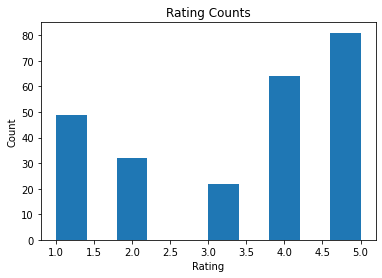

In [2]:
reviews = pd.read_csv("redmond_yelp_reviews.csv")

_ = plt.hist(reviews.rating)
_ = plt.xlabel("Rating")
_ = plt.ylabel("Count")
_ = plt.title("Rating Counts")

In [3]:
reviews = reviews[reviews.rating!=3]
reviews = reviews.reset_index()

for i in range(len(reviews)):
    row = reviews.iloc[i,:]
    row_rating = row.rating
    if row_rating <= 2:
        reviews.loc[i,"sentiment"] = "negative"
    else:
        reviews.loc[i,"sentiment"] = "positive"
        
reviews.head()

,index,id,name,city,state,date,rating,text,sentiment
0,0,1,Morgan B.,Bellingham,WA,12/24/2021,5,Amazing Thai food. We had our in office partie...,positive
1,1,2,Shay C.,Vancouver,WA,12/26/2021,1,Ordered here with Uber Eats on 12/26 when it w...,negative
2,2,3,Sarah S.,Seattle,WA,7/5/2021,5,"We ordered our usual- the Phad Thai, Phad See ...",positive
3,3,4,Michael S.,Carnation,WA,12/6/2021,1,Food was soggy and runny. Portions were large ...,negative
4,4,5,Mo P.,Camarillo,CA,6/20/2021,5,Delicious food and wonderful service. Both ind...,positive


In [4]:
for i in range(len(reviews)):
    row = reviews.iloc[i,:]
    row_text = row.text
    if type(row_text) is str:
        reviews.loc[i,"text_no_punct"] = row_text.translate(str.maketrans("","",string.punctuation))
    else:
        reviews.loc[i,"text_no_punct"] = ""
    
reviews.head()

,index,id,name,city,state,date,rating,text,sentiment,text_no_punct
0,0,1,Morgan B.,Bellingham,WA,12/24/2021,5,Amazing Thai food. We had our in office partie...,positive,Amazing Thai food We had our in office parties...
1,1,2,Shay C.,Vancouver,WA,12/26/2021,1,Ordered here with Uber Eats on 12/26 when it w...,negative,Ordered here with Uber Eats on 1226 when it wa...
2,2,3,Sarah S.,Seattle,WA,7/5/2021,5,"We ordered our usual- the Phad Thai, Phad See ...",positive,We ordered our usual the Phad Thai Phad See Iw...
3,3,4,Michael S.,Carnation,WA,12/6/2021,1,Food was soggy and runny. Portions were large ...,negative,Food was soggy and runny Portions were large b...
4,4,5,Mo P.,Camarillo,CA,6/20/2021,5,Delicious food and wonderful service. Both ind...,positive,Delicious food and wonderful service Both indo...


In [5]:
count_vec = CountVectorizer()
word_counts = count_vec.fit_transform(reviews.text_no_punct)
count_words = count_vec.get_feature_names()
word_counts = csr_matrix(word_counts)

word_counts_reviews = pd.DataFrame(word_counts.toarray(),index=reviews.index,columns=count_words)
word_counts_reviews["sentiment"] = reviews.sentiment
word_counts_reviews['text_no_punct'] = reviews.text_no_punct
word_counts_reviews['text'] = reviews.text

tf_idf_vec = TfidfVectorizer(max_df=0.95)
tf_idf = tf_idf_vec.fit_transform(reviews.text_no_punct)
tf_idf_words = tf_idf_vec.get_feature_names()
tf_idf = csr_matrix(tf_idf)

tf_idf_reviews = pd.DataFrame(tf_idf.toarray(),index=reviews.index,columns=tf_idf_words)
tf_idf_reviews["sentiment"] = reviews.sentiment
tf_idf_reviews['text_no_punct'] = reviews.text_no_punct
tf_idf_reviews['text'] = reviews.text


In [6]:
word_counts_val_accuracies = []
tf_idf_val_accuracies = []

for i in range(20):

    word_counts_train, word_counts_test = train_test_split(word_counts_reviews,test_size=0.2)
    word_counts_val, word_counts_test = train_test_split(word_counts_test,test_size=0.5)

    tf_idf_train, tf_idf_test = train_test_split(tf_idf_reviews,test_size=0.2)
    tf_idf_val, tf_idf_test = train_test_split(tf_idf_test,test_size=0.5)

    # No regularization

    word_counts_model = LogisticRegression(penalty='l2',C=1e25)
    word_counts_model.fit(word_counts_train[count_words],word_counts_train.sentiment)

    tf_idf_model = LogisticRegression(penalty='l2',C=1e25)
    tf_idf_model.fit(tf_idf_train[tf_idf_words],tf_idf_train.sentiment)

    word_counts_model_predictions = word_counts_model.predict(word_counts_val[count_words])
    word_counts_model_val_accuracy = accuracy_score(word_counts_val.sentiment,word_counts_model_predictions)
    word_counts_val_accuracies.append(word_counts_model_val_accuracy)
    #print("Word Counts Model Accuracy:",word_counts_model_val_accuracy)

    tf_idf_model_predictions = tf_idf_model.predict(tf_idf_val[tf_idf_words])
    tf_idf_model_val_accuracy = accuracy_score(tf_idf_val.sentiment,tf_idf_model_predictions)
    tf_idf_val_accuracies.append(tf_idf_model_val_accuracy)
    #print("Tf-idf Model Accuracy:",tf_idf_model_val_accuracy)
    
print("Word Count Model Mean Accuracy:",np.mean(word_counts_val_accuracies))
print("Tf-idf Model Mean Accuracy:",np.mean(tf_idf_val_accuracies))

Word Count Model Mean Accuracy: 0.8717391304347825
Tf-idf Model Mean Accuracy: 0.8630434782608696


In [7]:
tf_idf_train, tf_idf_test = train_test_split(tf_idf_reviews,test_size=0.2)
tf_idf_val, tf_idf_test = train_test_split(tf_idf_test,test_size=0.5)

tf_idf_model = LogisticRegression(penalty='l2',C=1e25)
tf_idf_model.fit(tf_idf_train[tf_idf_words],tf_idf_train.sentiment)

LogisticRegression(C=1e+25)

In [8]:
tf_idf_models = []

for reg_coeff in np.logspace(-5,5,10):
    tf_idf_model = LogisticRegression(penalty='l2',C=1/reg_coeff)
    tf_idf_model.fit(tf_idf_train[tf_idf_words],tf_idf_train.sentiment)
    val_predictions = tf_idf_model.predict(tf_idf_val[tf_idf_words])
    val_accuracy = accuracy_score(tf_idf_val.sentiment,val_predictions)
    tf_idf_models.append({
        "reg_coeff": reg_coeff,
        "model": tf_idf_model,
        "val_accuracy": val_accuracy
    })
    
tf_idf_models = pd.DataFrame(tf_idf_models)

In [9]:
best_model_index = tf_idf_models.val_accuracy.idxmax()
best_model_row = tf_idf_models.iloc[best_model_index,:]
tf_idf_model = best_model_row.model

In [10]:
coeffs = tf_idf_model.coef_[0]
coeffs_df = pd.DataFrame(coeffs)

most_positive_word_index = coeffs_df[0].idxmax()
most_positive_word = tf_idf_words[most_positive_word_index]
print("Most positive word is",most_positive_word)

most_negative_word_index = coeffs_df[0].idxmin()
most_negative_word = tf_idf_words[most_negative_word_index]
print("Most negative word is",most_negative_word)

Most positive word is great
Most negative word is rude


In [11]:
val_pred_probs = pd.DataFrame(tf_idf_model.predict_proba(tf_idf_val[tf_idf_words]),columns=["negative_prob","positive_prob"])

negative_pred_probs = val_pred_probs.negative_prob
most_negative_index = negative_pred_probs.idxmax()
most_negative_review = tf_idf_reviews.iloc[most_negative_index,:]
most_negative_review_text = most_negative_review.text
print("The most negative review in validation set (based on current model):")
print()
print(textwrap.fill(most_negative_review_text,150))
print()

positive_pred_probs = val_pred_probs.positive_prob
most_positive_index = positive_pred_probs.idxmax()
most_positive_review = tf_idf_reviews.iloc[most_positive_index,:]
most_positive_review_text = most_positive_review.text
print("The most positive review in validation set (based on current model):")
print()
print(textwrap.fill(most_positive_review_text,150))


The most negative review in validation set (based on current model):

Have been 3 times in last 6 months.  First visit was great! 2nd visit not edible, ordered beef phad Thai, dry, horrible.  Last visit, gross, Phad Thai
was sticky, crab fried rice had clumps of cold rice in it!  Not fresh, service was rude!  Tea was sickening sweet asked for more milk, she glared and
barely changed it, then sat container overflowing on counter.   I don't earn my money to give it to bad food and horrible service!

The most positive review in validation set (based on current model):

We ordered our usual- the Phad Thai, Phad See Iw with chicken, and Phad Kee Mao Chicken to go. One thing I love about Silver Spoon is that their spice
levels have a lot of range. While I prefer my food on the spicier side, we were able to share the 1 and 2 star levels comfortably with the extended
family. For my own self, I would prefer 4 or 5 star, but with that being said, their flavors hold up and are wonderful even with

In [12]:
test_pred_probs = pd.DataFrame(tf_idf_model.predict_proba(tf_idf_test[tf_idf_words]),columns=["negative_prob","positive_prob"])

negative_pred_probs = test_pred_probs.negative_prob
most_negative_index = negative_pred_probs.idxmax()
most_negative_review = tf_idf_reviews.iloc[most_negative_index,:]
most_negative_review_text = most_negative_review.text
print("The most negative review in test set (based on current model):")
print()
print(textwrap.fill(most_negative_review_text,150))
print()

positive_pred_probs = test_pred_probs.positive_prob
most_positive_index = positive_pred_probs.idxmax()
most_positive_review = tf_idf_reviews.iloc[most_positive_index,:]
most_positive_review_text = most_positive_review.text
print("The most positive review in test set (based on current model):")
print()
print(textwrap.fill(most_positive_review_text,150))


The most negative review in test set (based on current model):

As a gluten free / dairy free foodie, I appreciate this restaurant! Their food is not only accommodating to my dietary restrictions, but also
delicious. I'm never disappointed by my order of Golden Noodles with vegetables and extra vegetables or Thai fried rice with tofu and extra
vegetables. The quality had NOT changed since Covid. The wait times for pick up are reasonable and they have created a pick up environment that is
convenient and safe.

The most positive review in test set (based on current model):

Folks. This Thai place rocks. They never wavered during covid and still create fantastic dishes. They are open for indoor and outdoor (or soon will
be) dining. They really are exceptional in quality of food flavor and overall experience. And obviously other people think so too. Always a stack of
orders in waiting for pickup. Thank you SS. Btw the Siracha noodles is tasty! Something different.


In [13]:
pred_probs = pd.DataFrame(tf_idf_model.predict_proba(tf_idf_reviews[tf_idf_words]),columns=["negative_prob","positive_prob"])

negative_pred_probs = pred_probs.negative_prob
most_negative_index = negative_pred_probs.idxmax()
most_negative_review = tf_idf_reviews.iloc[most_negative_index,:]
most_negative_review_text = most_negative_review.text
print("The most negative review (based on current model):")
print()
print(textwrap.fill(most_negative_review_text,150))
print()

positive_pred_probs = pred_probs.positive_prob
most_positive_index = positive_pred_probs.idxmax()
most_positive_review = tf_idf_reviews.iloc[most_positive_index,:]
most_positive_review_text = most_positive_review.text
print("The most positive review (based on current model):")
print()
print(textwrap.fill(most_positive_review_text,150))

The most negative review (based on current model):

The food is not good.  It's close to home but not on our list of top 10.   After this evenings meal i vow to not go back again.  This is not the issue
however.  The service is miserable.  They are very rude.  Little english, but it's not a a language issue - they are just extremely rude.  Not people
who should be in food service or customer service.

The most positive review (based on current model):

I love this place, I go here at least once a month. It is always clean, fast and great service and excellent food!
